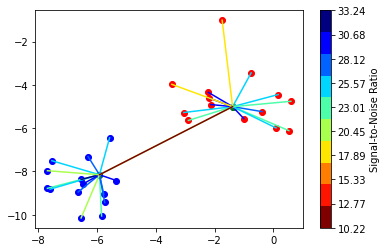

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from modifying_KMeans_snr import cluster_former
import copy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 30
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/iiitd/anaconda3/envs/FL/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.01
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)


In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp)  
#                 params=adam(params)
            
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))

In [11]:
torch.manual_seed(args.torch_seed)

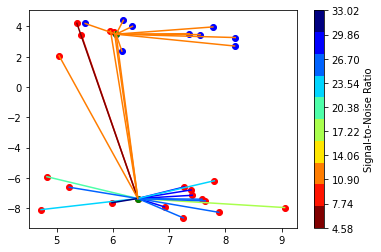

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.386280


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  response = method(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you

Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 2.229048
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.618776

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.249351
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.725381
Model client20 Train Epoch: 3 [0/320 (0%)]	Loss: 0.782888

Power Allocated= 1.2150648511448483
CSI= 0.3990857849239934
SNR= 20.124450640365534
Client: client21
Model client21 Train Epoch: 1 [0/320 (0%)]	Loss: 2.463270
Model client21 Train Epoch: 2 [0/320 (0%)]	Loss: 1.301921
Model client21 Train Epoch: 3 [0/320 (0%)]	Loss: 0.310383

Power Allocated= 2.09750530781649
CSI= 0.6160342086062711
SNR= 28.23694057476962
Client: client23
Model client23 Train Epoch: 1 [0/320 (0%)]	Loss: 2.274818
Model client23 Train Epoch: 2 [0/320 (0%)]	Loss: 2.105675
Model client23 Train Epoch: 3 [0/320 (0%)]	Loss: 1.557596

Power Allocated= 2.0550203037458132
CSI= 0.600322440117720

/tmp/ipykernel_4116387/809122911.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.18888656106086488
SNR= 8.915213729955088
Client: client29
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster2 model: 2.3004, Accuracy: 1205/10000 (12%)


Test set: Average loss for Final  model: 2.3014, Accuracy: 959/10000 (10%)

1


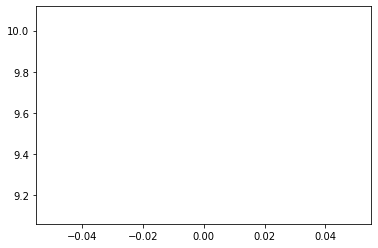

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280787
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.996771
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.048103

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.311060
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.803600
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.216727

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

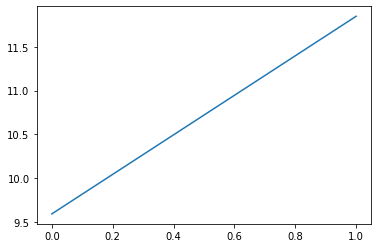

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293406
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 2.061332
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.776230

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.318711
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.947439
Model client20 Train Ep

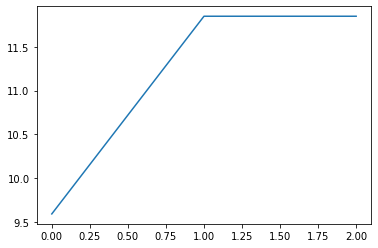

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.363560
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 2.324299
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 2.227589

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278682
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.864894
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.520188

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

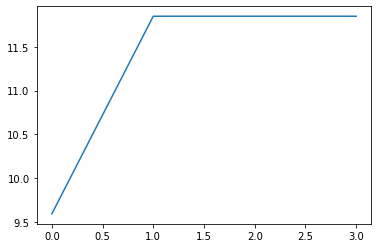

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.313101
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 2.271515
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 2.167803

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.266051
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.779983
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.342777

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

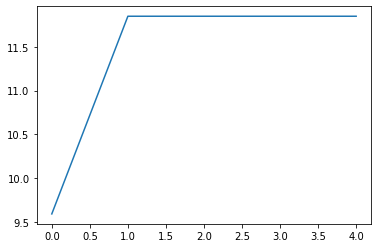

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.329795
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 2.115494
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.877933

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.259772
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.637459
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.162710

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

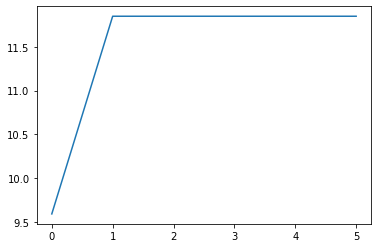

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.263486
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.557708
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.170445

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.398035
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.209187
Model client20 Train Ep

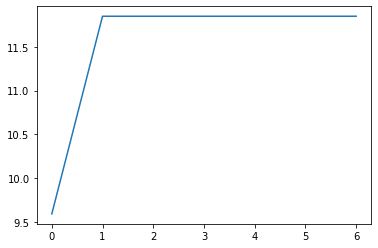

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.268492
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.472053
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.112575

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.433374
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.037598
Model client20 Train Ep

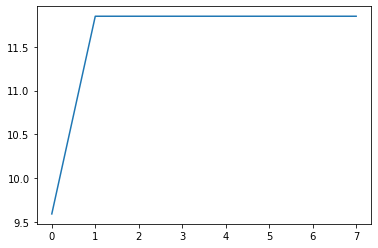

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.543712
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 2.303478
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 2.034830

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.269005
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.404571
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.033699

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

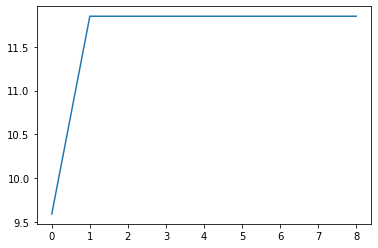

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.408042
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 2.123918
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 2.050309

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.268406
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.347006
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.957762

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

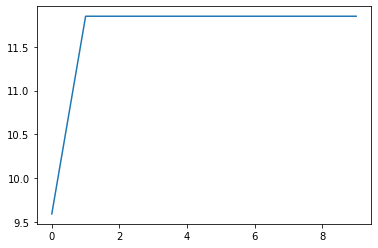

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.390269
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 2.082741
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.711400

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.329853
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.925517
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.608193

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.239579
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.234443
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.607994

Power Allo

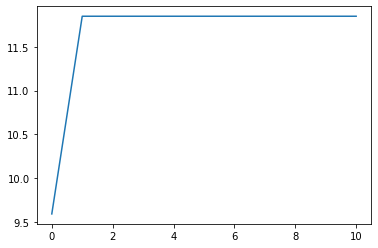

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.433513
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.869747
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.390108

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.328223
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.806235
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.335259

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.540060
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 2.121259
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.750321

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.263462
Model client

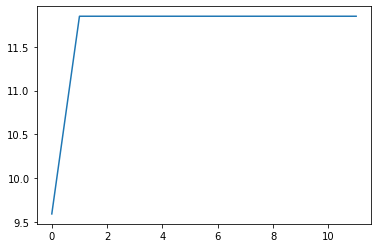

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293084
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.610852
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.103960

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199130
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.201883
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.390719

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

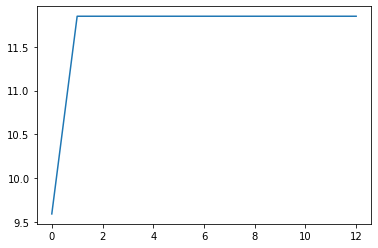

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.312561
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.432226
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.158022

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.686930
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 2.049124
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.580474

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.237069
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.084695
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.600508

Power Allo

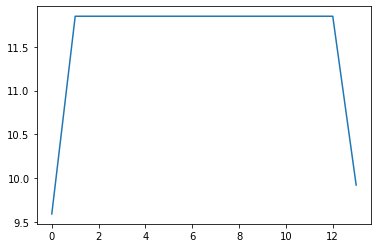

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.376969
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.568658
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.214969

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.632690
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.878515
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.433288

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.260988
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.126220
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.517242

Power Allo

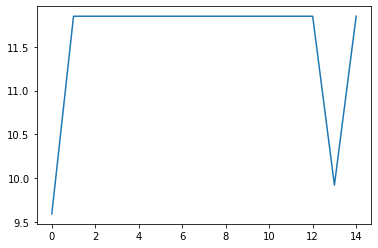

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.309491
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.410693
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.114916

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.621568
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.785043
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.357697

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199032
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.985994
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.360547

Power Allo

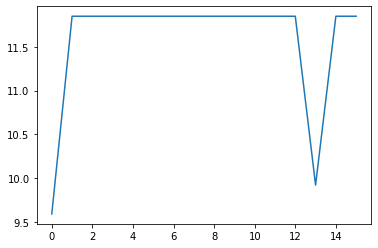

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.386289
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.597625
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.270502

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.575785
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.674184
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.247952

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.247014
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.053095
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.397544

Power Allo

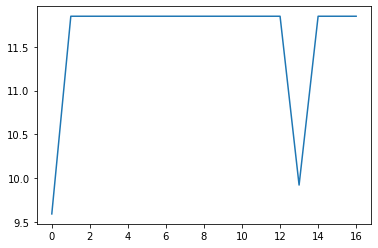

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.340490
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.401282
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.172144

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.236404
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.771778
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.468559

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

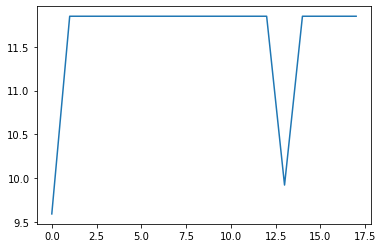

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.561001
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.614776
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.232063

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.347647
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.338931
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.107885

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.229995
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.854937
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.243723

Power Allo

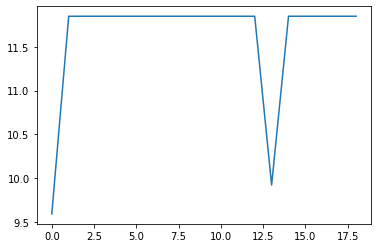

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.618499
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.487475
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.136609

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.206415
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.653263
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.580487

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

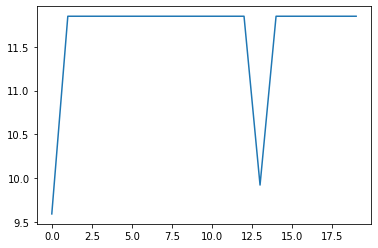

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.352318
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.304481
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.098836

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.227838
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.841482
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.194027

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

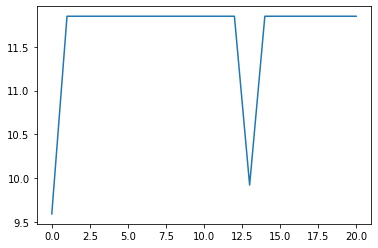

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.226119
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.664293
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.689555

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.545960
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.464940
Model client20 Train Ep

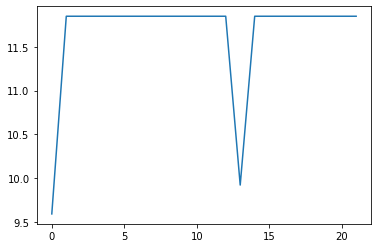

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.314569
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.256886
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.091910

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.204388
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.833639
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.196196

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

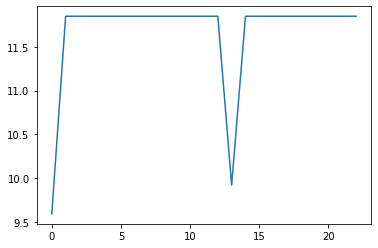

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293940
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.188985
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.042146

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.193161
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.591592
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.049043

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

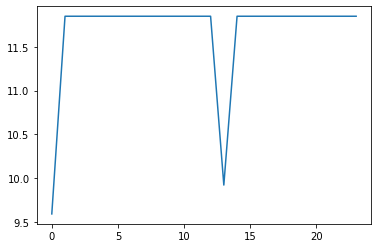

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.301301
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.189946
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.980546

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.186137
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.495383
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.245293

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

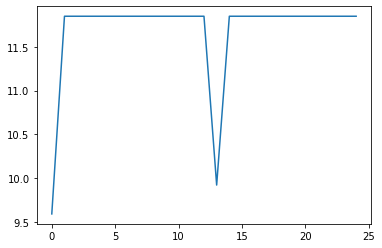

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.508274
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.472554
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.111027

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.179146
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.428871
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.142044

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

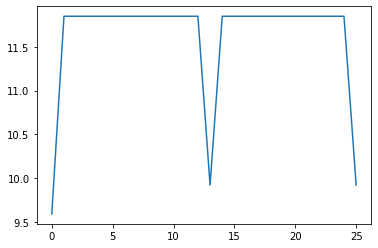

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.193012
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.364791
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.279387

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.605284
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.224001
Model client20 Train Ep

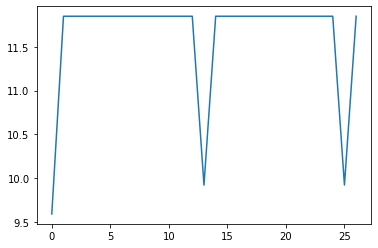

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.198316
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.395063
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.569803

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.611853
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.118338
Model client20 Train Ep

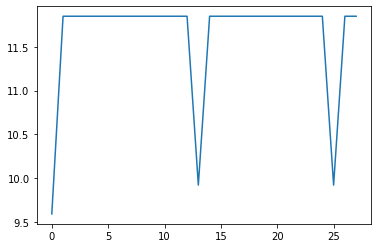

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.194238
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.495974
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.624492

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.747731
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.070035
Model client20 Train Ep

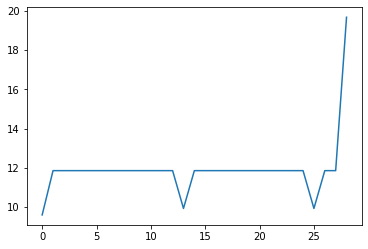

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.173639
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.450496
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.237224

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.689530
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.073695
Model client20 Train Ep

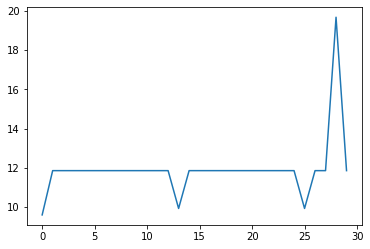

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.186926
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.442955
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.619606

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.815390
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.044767
Model client20 Train Ep

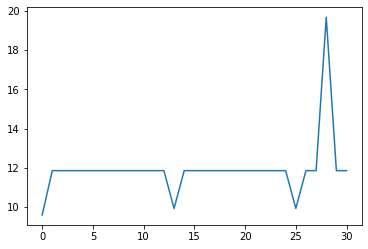

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.827603
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.625602
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.172284

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.166332
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.533369
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.256458

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

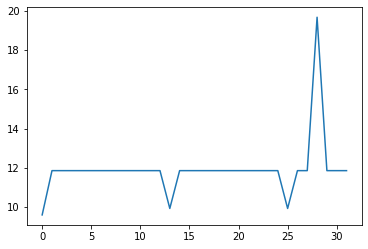

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.231617
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.451488
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.225740

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.627892
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.034061
Model client20 Train Ep

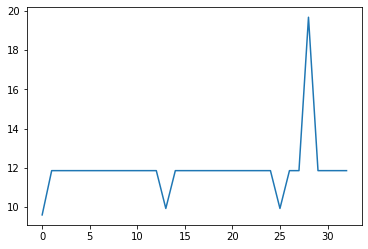

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.553408
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.313178
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 1.034559

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.358225
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.863174
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.619506

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.172184
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.247414
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.033963

Power Allo

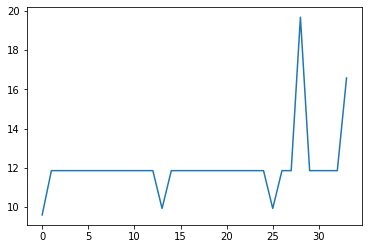

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.642729
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.153684
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.823079

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.217492
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.221094
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.013849

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

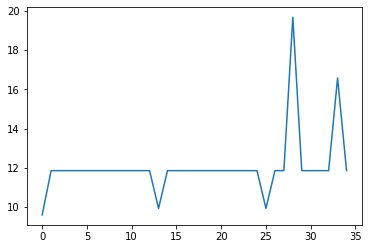

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.573597
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.105627
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.523403

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.169255
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.122796
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.044598

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

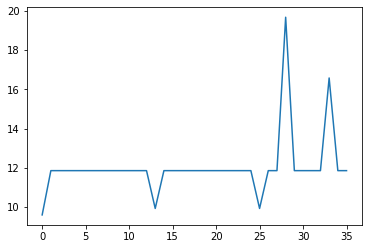

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.300749
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.932682
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.490843

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.902993
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.619478
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.142352

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.121731
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.166053
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.116007

Power Allo

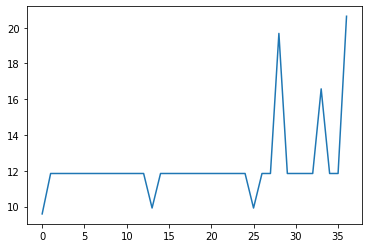

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.162157
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.081390
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002230

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.885905
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001025
Model client20 Train Ep

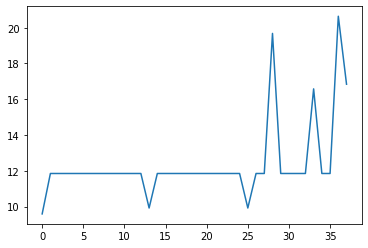

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.096075
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.106332
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.011866

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.789741
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.011182
Model client20 Train Ep

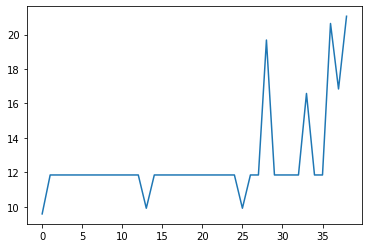

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.467498
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.862512
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.371927

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.201632
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.051949
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000062

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

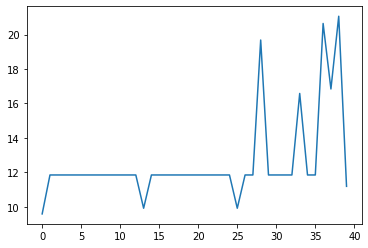

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.699711
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.564017
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.777764

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.385149
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.696577
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.648267

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.145027
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.106928
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.259208

Power Allo

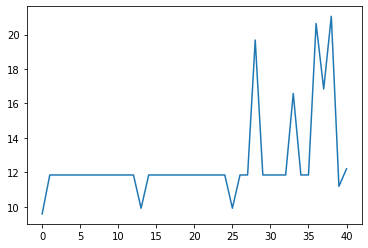

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.120703
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.564287
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.452438

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.662917
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000280
Model client20 Train Ep

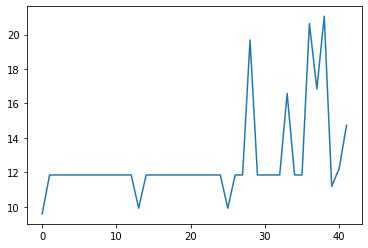

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.716265
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.010017
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.854096

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.124877
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.349620
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003912

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

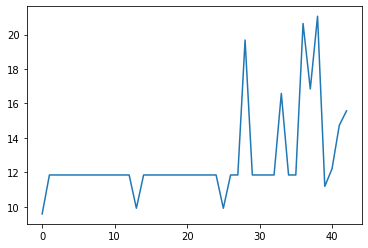

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.508936
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.830218
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.779874

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.750222
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.210100
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.881038

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.124855
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.469628
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.579156

Power Allo

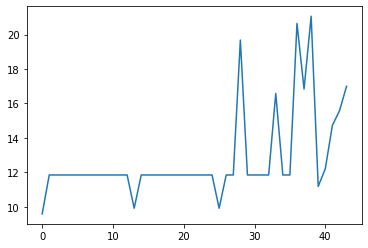

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.065714
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.093473
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.024726

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.768710
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.207080
Model client20 Train Ep

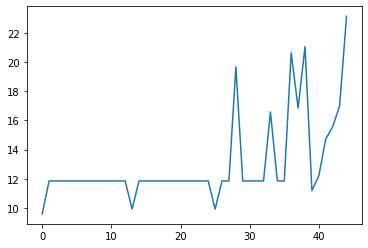

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293476
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.816075
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.536012

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.081901
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.015400
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.016580

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

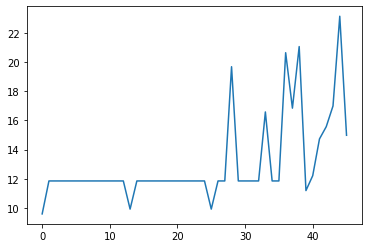

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.999228
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.089749
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.036834

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.721853
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.359649
Model client20 Train Ep

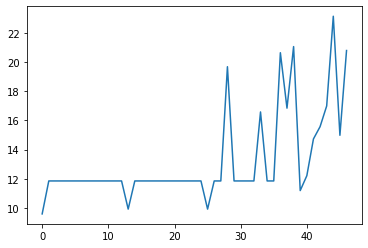

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.499294
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.899520
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.455454

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.983834
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.056439
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.698436

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.048834
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.023985
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.015835

Power Allo

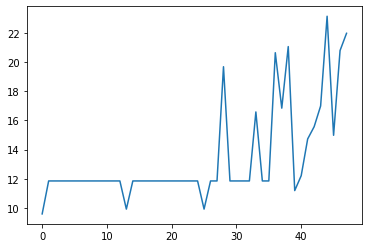

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.602822
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.691856
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.587353

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.030095
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.070284
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

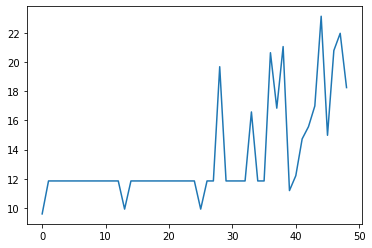

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.616154
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.550333
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.488040

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.147638
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.389442
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.235957

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.893016
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.013641
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

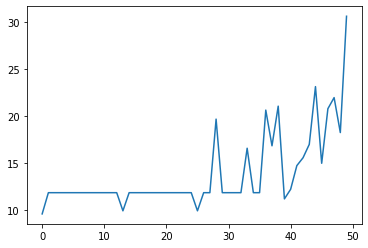

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.194340
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.745018
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.144638

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.897152
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.848803
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.445177

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.951134
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.561918
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.169356

Power Allo

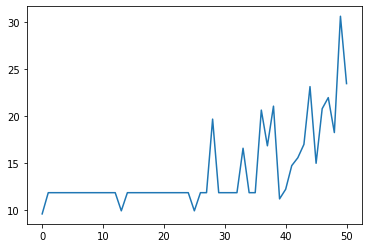

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.731551
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.448162
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.196928

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.775033
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.253884
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.067753

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

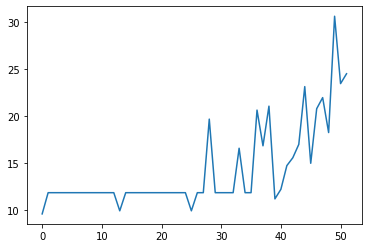

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.172862
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.789268
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.744456

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.907024
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004693
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.080451

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

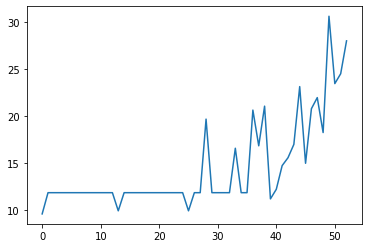

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.637630
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.607948
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.242910

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.221925
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.876791
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.429331

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.879700
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014532
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000029

Power Allo

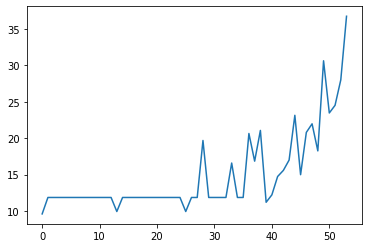

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.664775
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009349
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.622987
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008761
Model client20 Train Ep

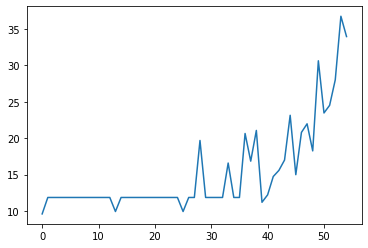

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.445433
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.297081
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.249499

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.998057
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.393374
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.066433

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.621079
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002119
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

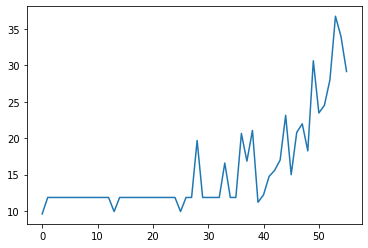

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.528165
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.436483
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.203722

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.221207
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.641854
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.346689

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.737304
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.011142
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

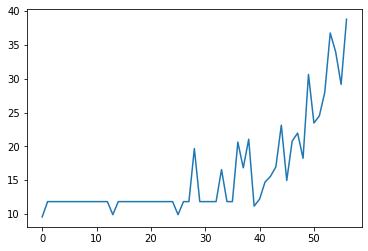

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.564855
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.228840
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.354008

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.575740
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.027627
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

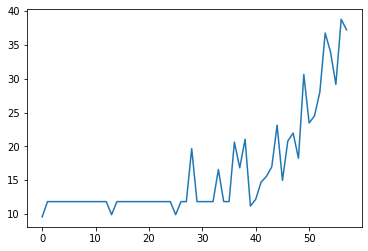

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.639971
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.332550
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.094635

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.847442
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000037
Model client20 Train Ep

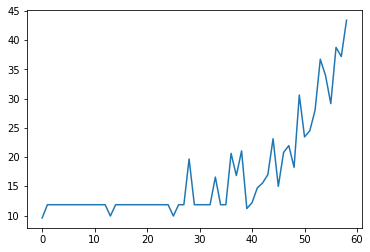

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.842837
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.089479
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.023860

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.530367
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.113902
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.671705

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

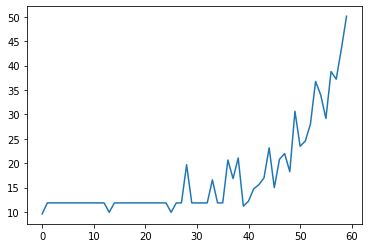

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.541071
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.265170
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.229206

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.887072
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.474416
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.133311

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.280083
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.073256
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.011224

Power Allo

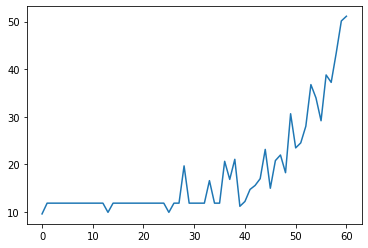

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.016164
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.433011
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.482610

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.343455
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.086569
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.215816

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

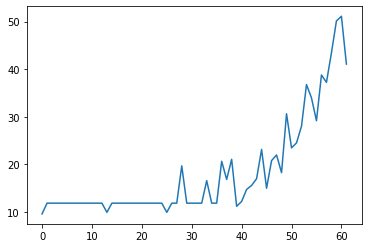

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.472507
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.084770
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.025679

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.537248
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014489
Model client20 Train Ep

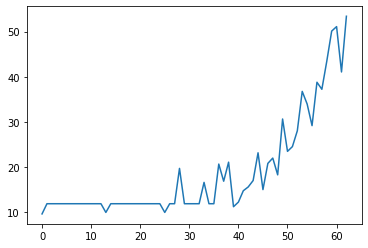

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.438043
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.461773
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.210909

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.078056
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.010065
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.205754

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

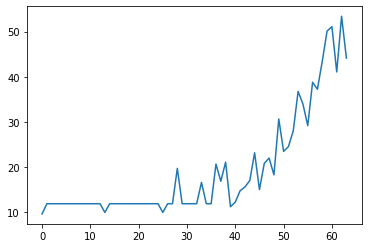

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.379726
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.155778
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.049148

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.651805
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.370514
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.425340

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.487072
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.010481
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

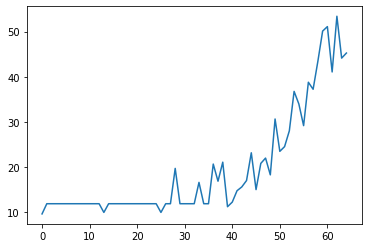

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.282866
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.039769
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.509265
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000071
Model client20 Train Ep

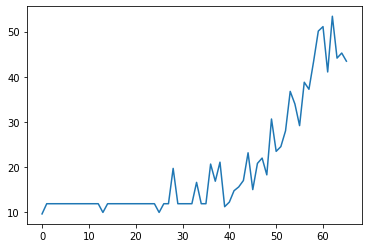

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.125520
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000318
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.630101
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000003
Model client20 Train Ep

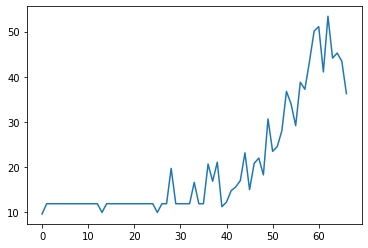

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.252016
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.411588
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.315913

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.484058
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014421
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

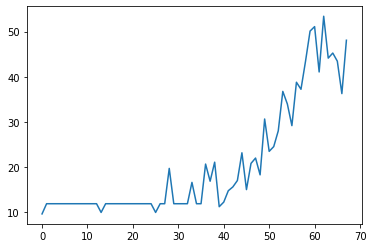

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.327138
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.174641
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.281613

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.771039
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.080081
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.187681

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.226699
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

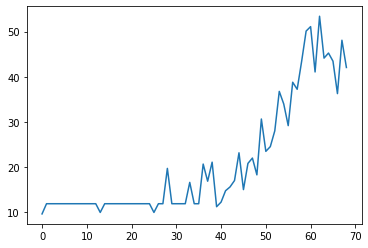

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.423887
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.056538
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.754532
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client20 Train Ep

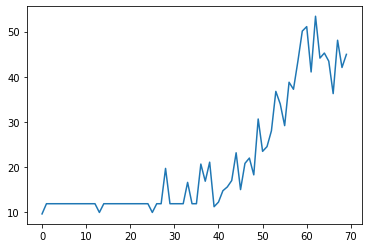

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.830992
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.270988
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.025575

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.303853
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.720327
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 2.191214

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

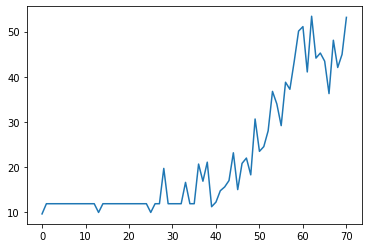

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.328003
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.220173
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.449116

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.244965
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.063272
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.013688

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

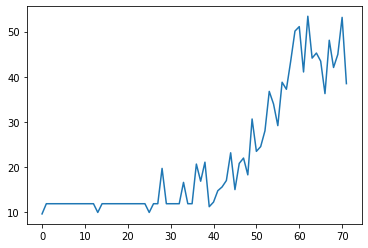

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.836410
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.110928
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.021675

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.412233
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.235818
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.551719

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

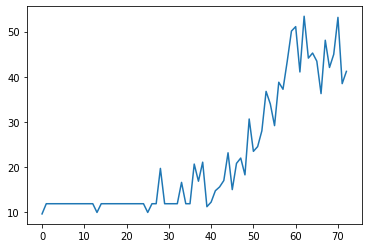

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.743546
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.060551
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.267796
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.084703
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.341215

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.346776
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.135204
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.060780

Power Allo

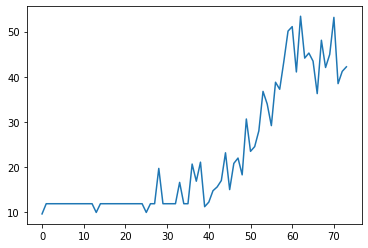

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.596235
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.111500
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000019

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.244650
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.409695
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.546004

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

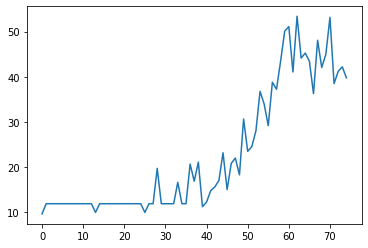

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.706985
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.079992
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.313242
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.274799
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

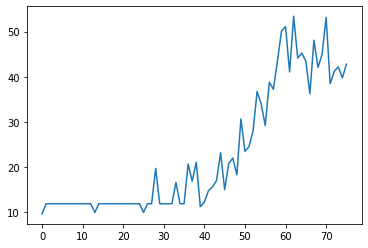

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.485509
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000029
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.550530
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.166788
Model client20 Train Ep

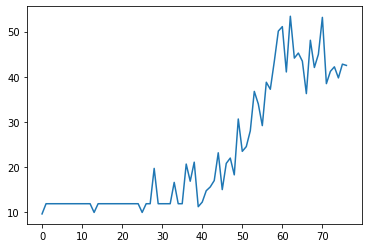

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.986633
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.334410
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.162245

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.256392
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.045189
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

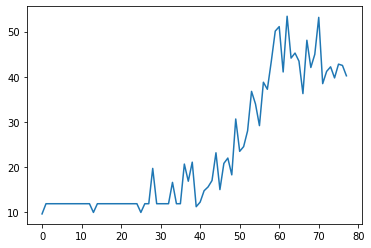

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.218017
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.146225
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.296021

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.442095
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 2.130099
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.480207

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

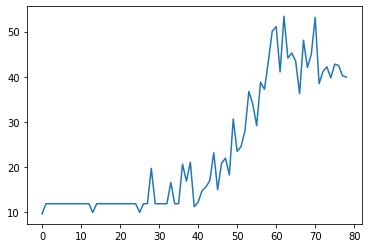

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.928457
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.235320
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.058203

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.450201
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.430586
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.673285

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

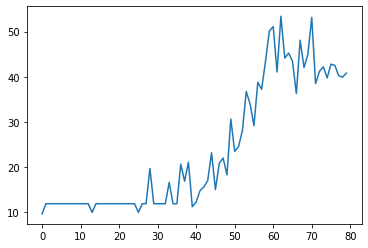

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.576785
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.159125
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.339429

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.804767
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

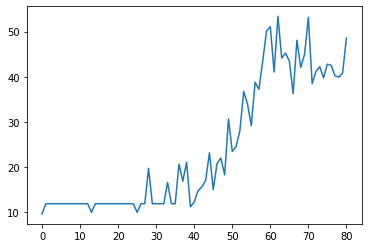

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.363066
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.363308
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.429239

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.405455
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.395068
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.262292

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

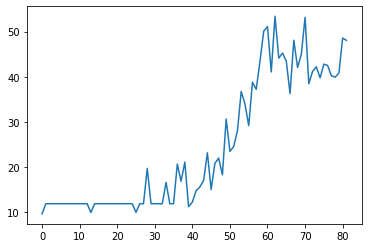

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.090339
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.381513
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.200602

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.692332
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.128472
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.447488
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007651
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.119295

Power Allo

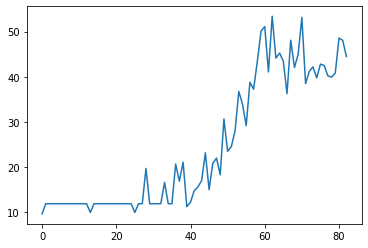

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.937703
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.306141
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.261870

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.574458
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.190526
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.174298

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

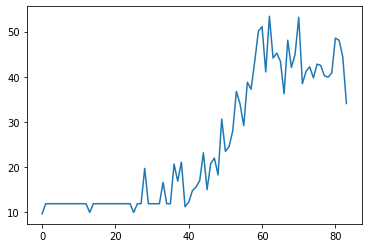

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.077421
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.060422
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.100765

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.652940
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.831627
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.205797

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

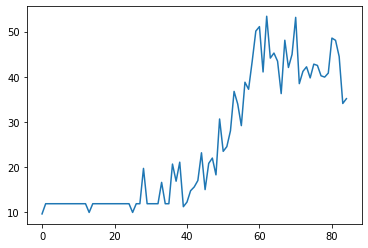

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.814968
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001577
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.022969

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.617353
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.037609
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003274

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

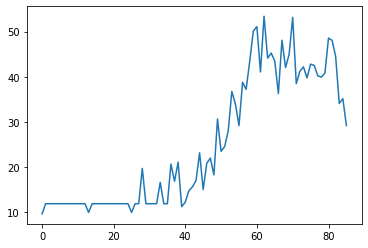

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.505790
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.231999
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.200178

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.856173
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.059865
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.091516

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

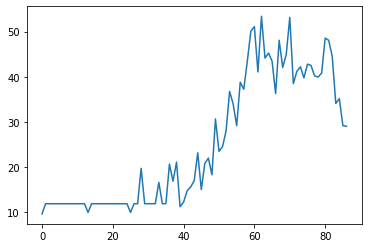

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.928856
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.317014
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000046

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.645077
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000014
Model client20 Train Ep

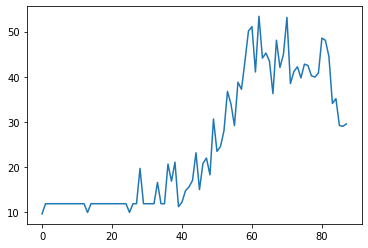

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.834085
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.227079
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.237612

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.854357
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.129948
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.090871

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

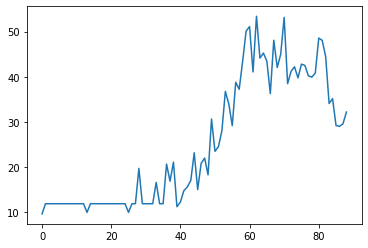

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.435859
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.338728
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001629

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.737615
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.720337
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.108972

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.694110
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.107370
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000478

Power Allo

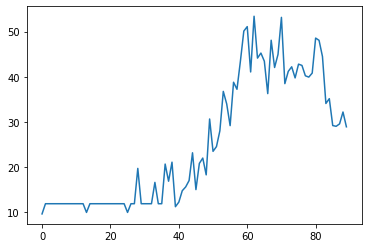

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.394811
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.267451
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.351615

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.829667
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000023
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000285

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

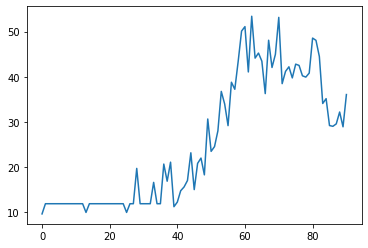

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.861548
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.235182
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.268113

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.530178
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

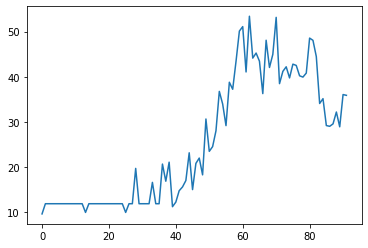

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.659686
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000177
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000076

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.625983
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

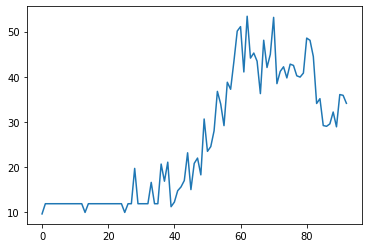

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.690057
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.515543
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.201349

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.621055
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000337
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

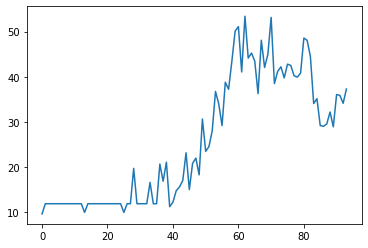

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.662000
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.193143
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.847121

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.681003
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000083
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

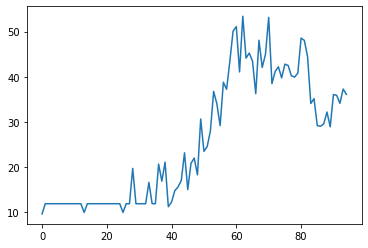

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.558921
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000055
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.861956
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

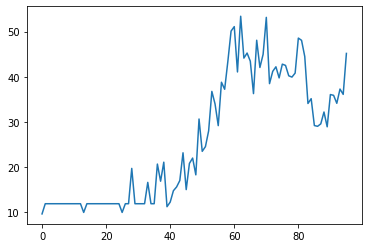

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.246847
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004497
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.475492
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.083658
Model client20 Train Ep

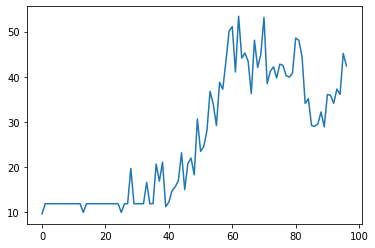

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.247258
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.842372
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

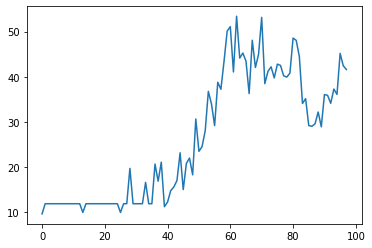

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.353791
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.068372
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.621946
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

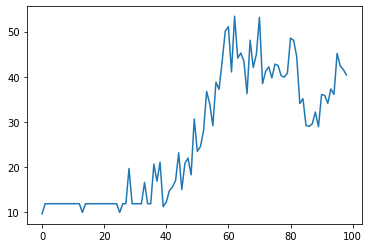

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.101523
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.261916
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.216832

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.209945
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

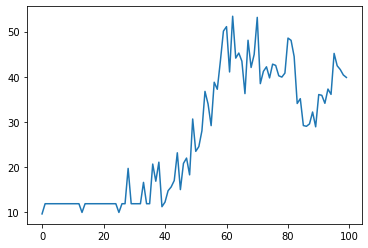

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.650939
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.100349
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.096501

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.480292
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000179
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

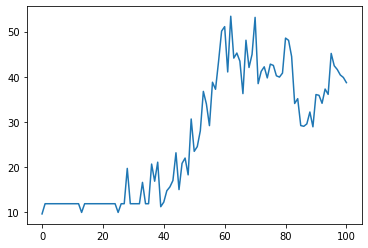

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.780900
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.142369
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.184245

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.303325
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

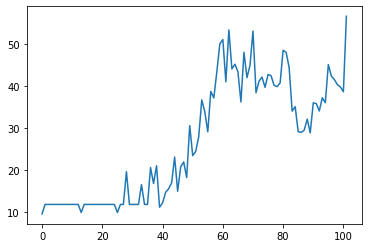

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.244846
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.352714
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.078372

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.790531
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

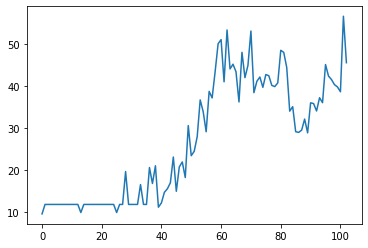

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.887144
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.720607
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

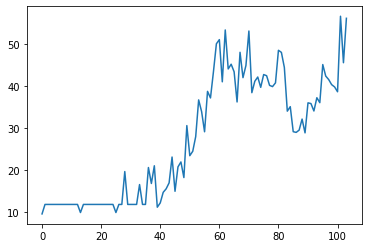

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.844517
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.571150
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

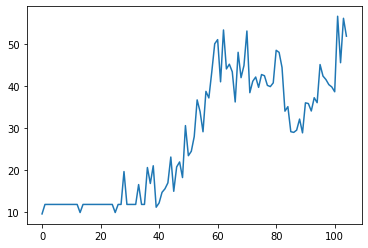

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.842681
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.113455
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.253991
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.094665
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.136732

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.827759
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

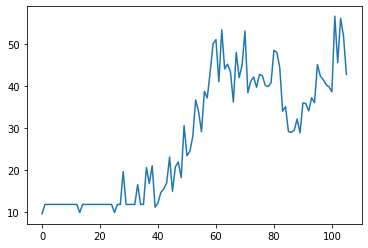

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.939938
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.166472
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.211905

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.263914
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

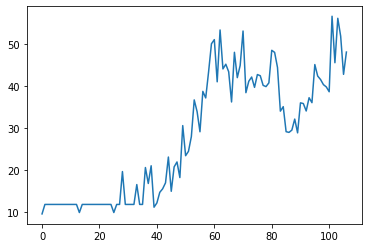

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.812088
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.093718
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003805

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.449920
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.224806
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.026545

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.005414
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

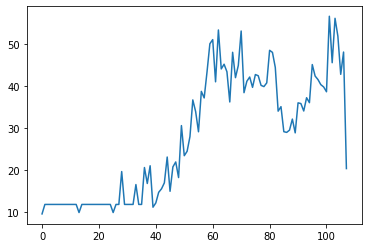

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.964530
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 2.993901
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.808735
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.034780
Model client20 Train Ep

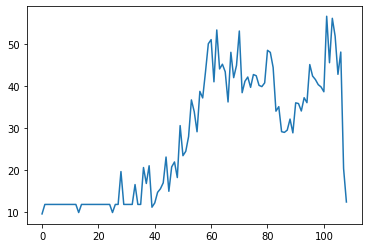

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.395538
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.368504
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.606207

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.224444
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 4.163862
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.233124

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

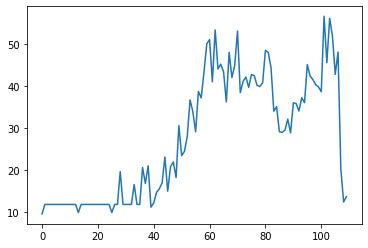

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.682380
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.473841
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.362555

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.132162
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.329778
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 8.748852

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

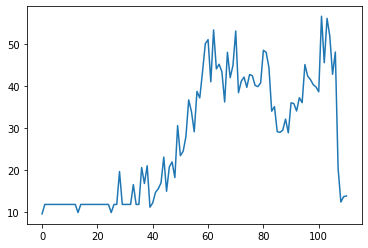

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.371143
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.900677
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.446473

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.119140
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.791541
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002002

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

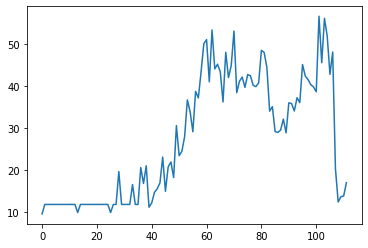

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.833144
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.658757
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.436358

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.993273
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.625985
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.953862

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

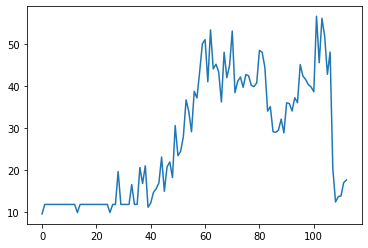

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.114829
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.683229
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.928408

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.612720
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000155
Model client20 Train Ep

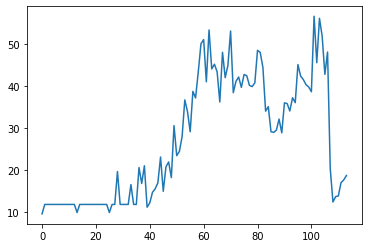

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.984780
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.148628
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.827821

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.595745
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005550
Model client20 Train Ep

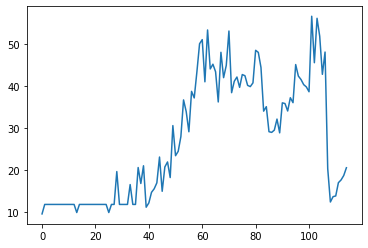

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.175299
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.169013
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 1.195938

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.743173
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.158253
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

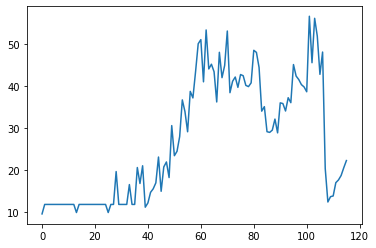

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.417856
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.960188
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.757683

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.856583
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.067203
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

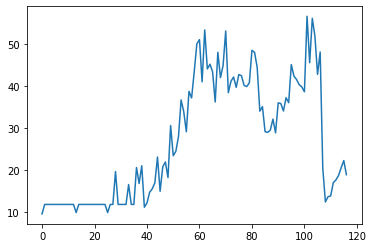

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.789575
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.258809
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.293481

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.072048
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.938355
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.638722

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.594350
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.221625
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

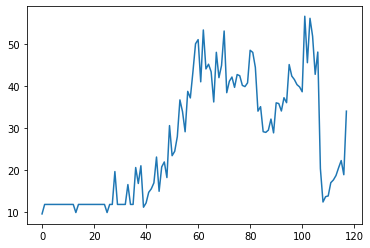

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.699707
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.517744
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.095886

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.083511
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.628296
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.554230

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.630637
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.158032
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

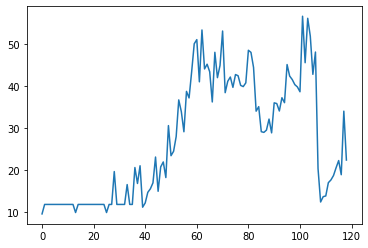

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.974831
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.025486
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.645706
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

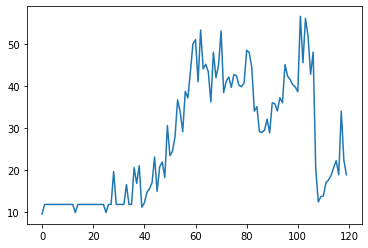

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.863319
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.019934
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.080585

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.358366
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

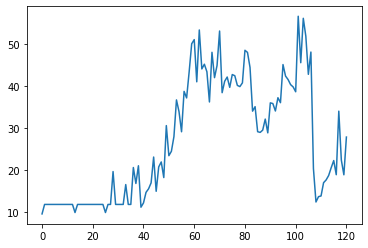

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.878445
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.212984
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.254115

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.120829
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

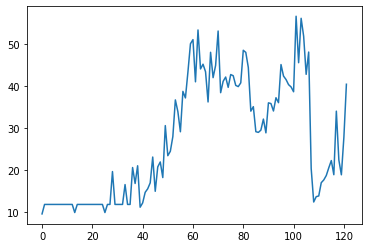

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.680264
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.904749
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.945545

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.423713
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.685464
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.320560

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.490243
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024180
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

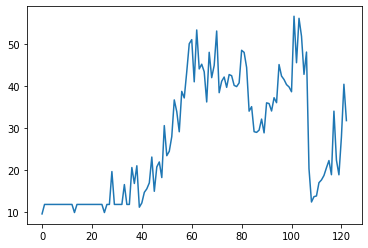

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.920859
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.249281
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.045073

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.586370
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.241565
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.228732

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.701704
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.520669
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.115165

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.721518
Model client

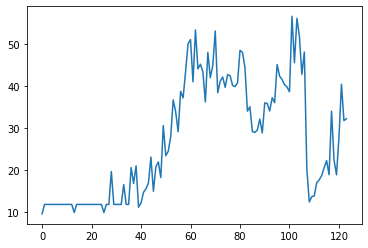

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.039426
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.270833
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.142671

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.690422
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.092305
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

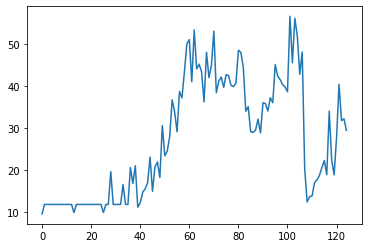

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.023578
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.121321
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.141088

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.773380
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006628
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

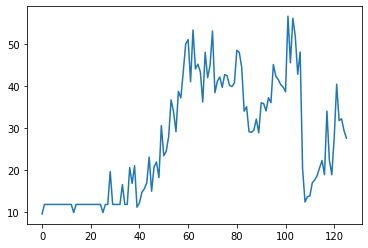

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.639716
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.013676
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.739100
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

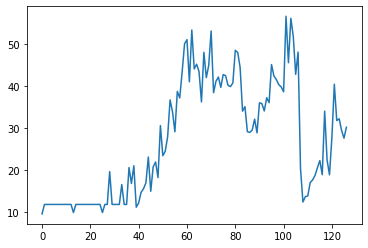

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.778975
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000065
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.817094
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

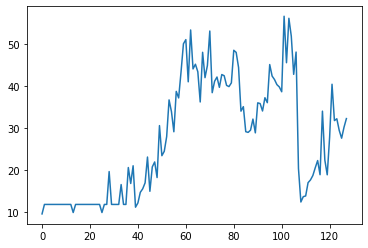

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.823288
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000061
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.228943
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

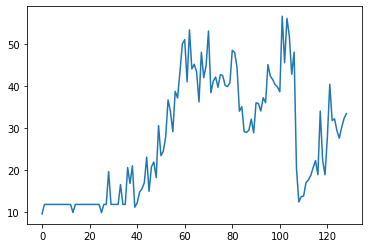

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.332696
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.182867
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.343882

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.875058
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.331798
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.332997

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.995117
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.597283
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.485297

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.612469
Model client

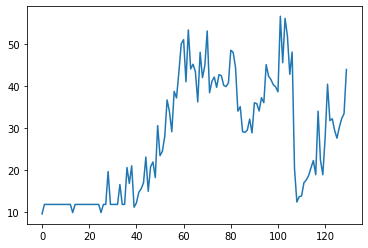

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.346236
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.560976
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.240155

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.394416
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

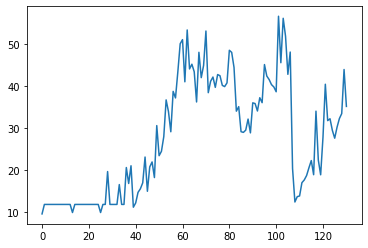

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.234127
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.358060
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.144721

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.604151
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.813051
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

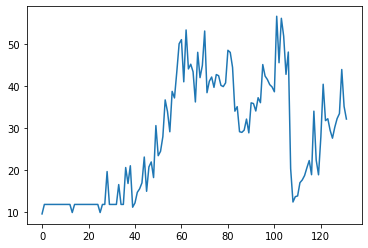

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.058672
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.284848
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.378063

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.796272
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.544029
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.052879

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.419494
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.677442
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

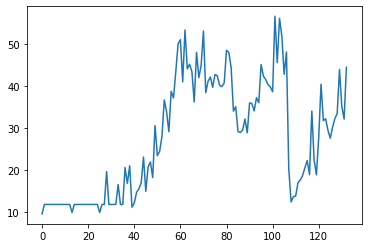

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.950671
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.048939
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.167997

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.545436
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.417751
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.426447

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.262144
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.806449
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.068603

Power Allo

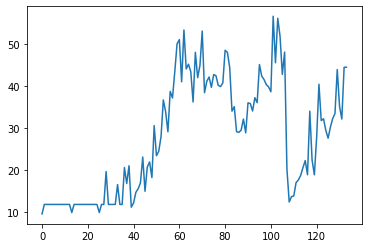

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.991933
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.079214
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.026804

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.488792
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.453463
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

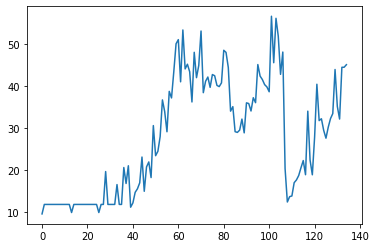

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.217786
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.573045
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client20 Train Ep

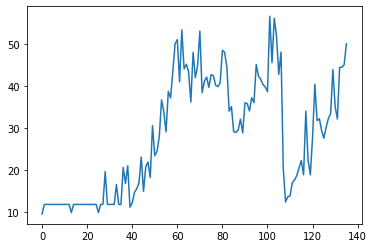

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.384859
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.207169
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.076517

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.130362
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

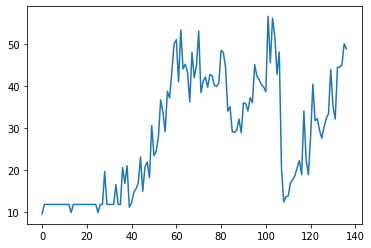

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.156772
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.245432
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.212146

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.143986
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

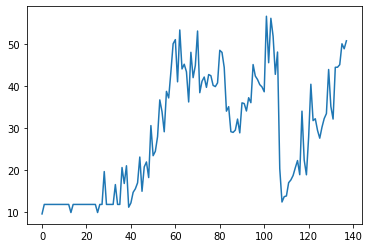

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.494895
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.124719
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.004760

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.429393
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.065891
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.137512

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.211127
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

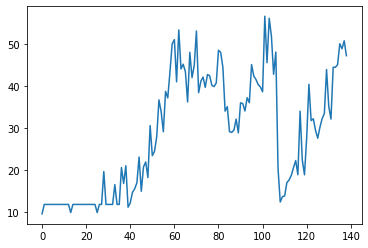

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.220354
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.710985
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000090

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.087554
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

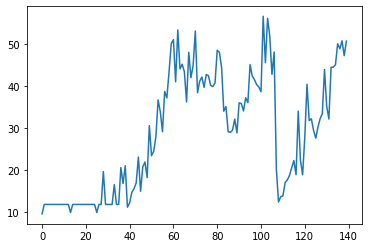

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.117783
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.570301
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 4.239055
Model client20 Train Ep

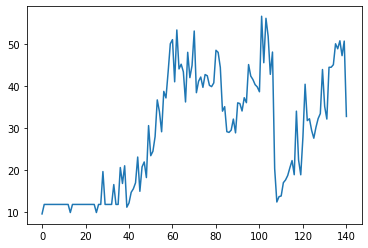

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.971700
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.158330
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001071

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.639370
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005134
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

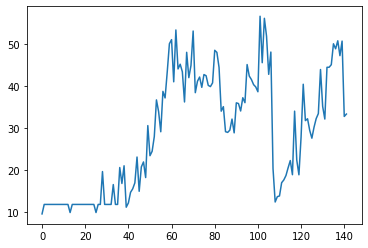

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.531143
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000007
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.438086
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 30.191586
Model client20 Train E

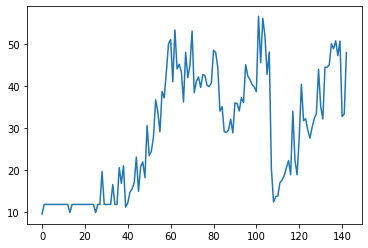

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.863958
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.272545
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.036319

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.422307
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

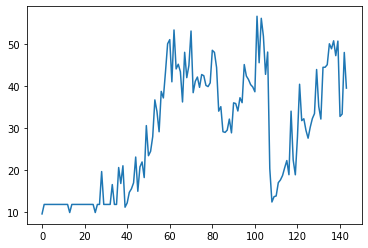

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.591013
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.278534
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.004926

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.374541
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000269
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

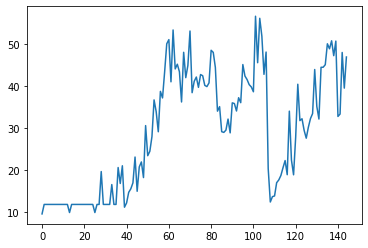

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.617229
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.384448
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.004769

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.531085
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000911
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

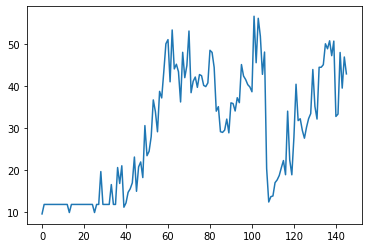

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.618895
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.550681
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.056011

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.329083
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000007
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

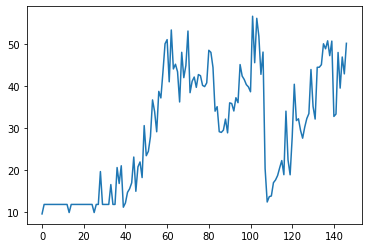

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.061913
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.291111
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.623797

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.243771
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

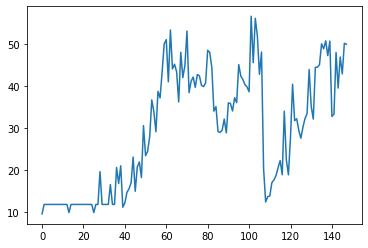

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.396525
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.220664
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.604297
Model client20 Train Ep

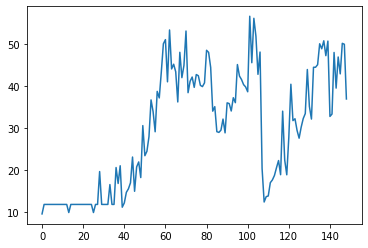

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.929778
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.389400
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.145145

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.681543
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 4.044020
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

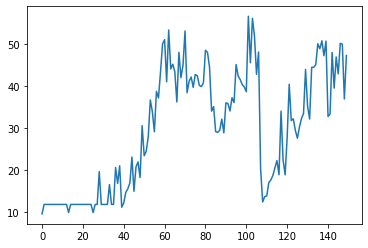

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.266229
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.295876
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 6.432831

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.621356
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.559067
Model client20 Train Ep

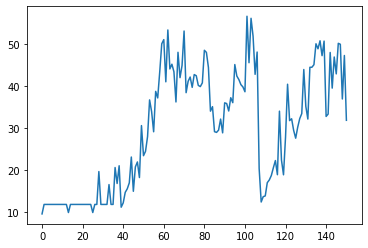

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.892919
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.191738
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.027949

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.102880
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.281718
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.133163

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.716581
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.363845
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 3.714840

Power Allo

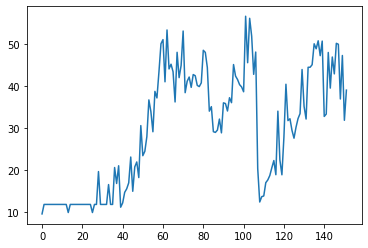

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.568773
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.969247
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.996858
Model client20 Train Ep

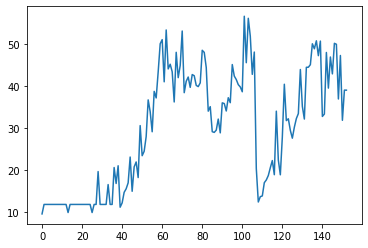

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.440634
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 3.471117
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.697560

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.451779
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.707781
Model client20 Train Ep

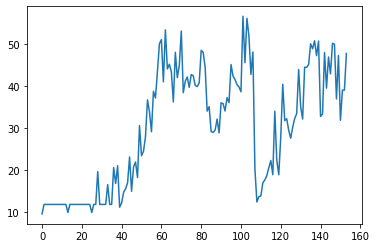

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.654165
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.457093
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.524287

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.134229
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 2.183849
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.076526

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

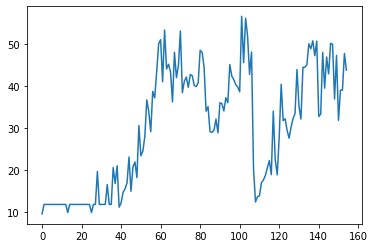

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.117720
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.166026
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.380367

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.579510
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.300459
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.167904

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.422837
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.363977
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.434071

Power Allo

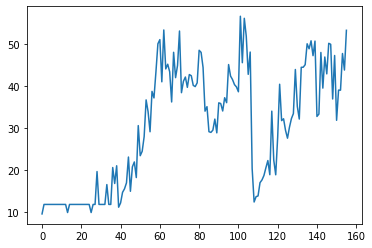

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 0.830806
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.287988
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.037856

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.740588
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.366767
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.051562

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.950962
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.030116
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.647205

Power Allo

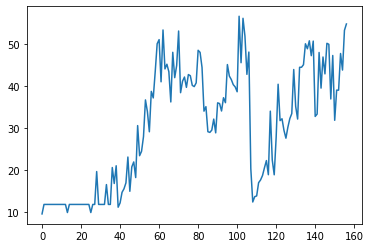

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.131671
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.753598
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 2.675864

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 1.432445
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.118768
Model client20 Train Ep

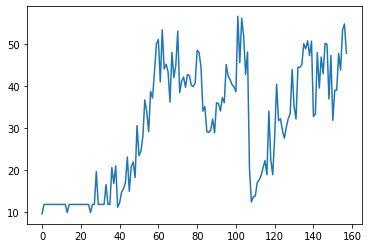

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.333135
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.811445
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 2.222372

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 1.662094
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.842164
Model client20 Train Ep

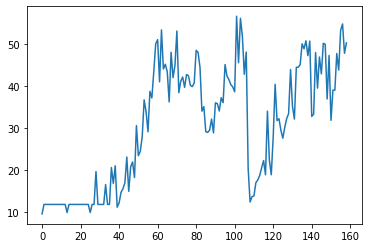

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.382105
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.154747
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.311793

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.180726
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.309496
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.435021

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

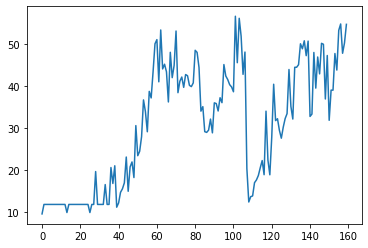

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.245139
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.071074
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.069697

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.734153
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.564958
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.058718

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

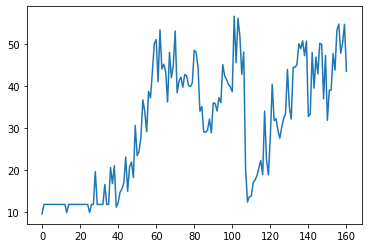

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.213647
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.164229
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.367746

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.193020
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.448429
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.034921

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.054133
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 4.393928
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allo

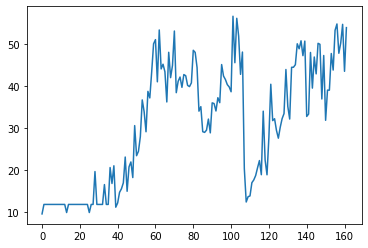

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 0.865122
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.778655
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.096319

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.849975
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.342763
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

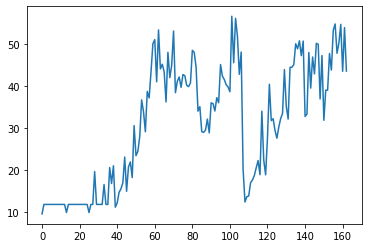

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.260801
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 6.009185
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.101144

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.347014
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.633240
Model client20 Train Ep

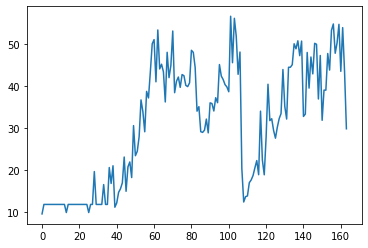

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.331120
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.070090
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.031287

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.727684
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.393507
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.365338

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

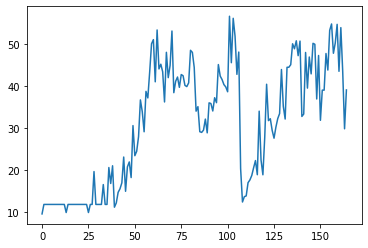

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.150927
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.241820
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001885

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.404000
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.130594
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 7.766659

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

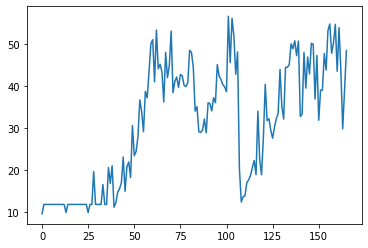

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.454142
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.061925
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.084321
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.612048
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.625549

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

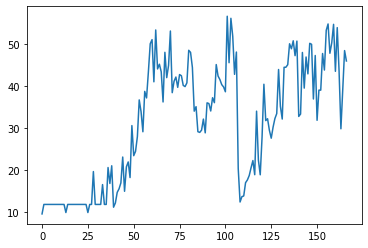

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 1.902820
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.130844
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.023411

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.457026
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.476357
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 4.873332

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

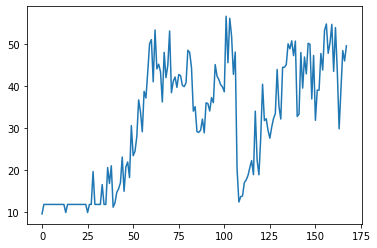

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.120051
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.251583
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.049751

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.978473
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.241720
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.993042

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

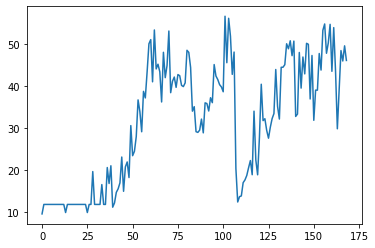

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.173350
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.708734
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.512323

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 1.658650
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 1.253043
Model client20 Train Ep

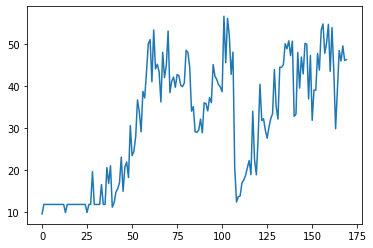

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.494712
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009947
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000003

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.076524
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 1.012800
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 1.710263

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

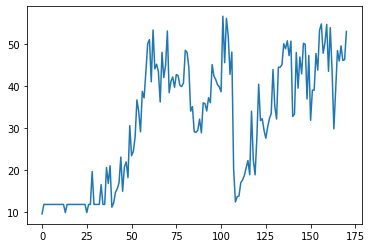

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.218179
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.181840
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000097

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.140926
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.376426
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.932121

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

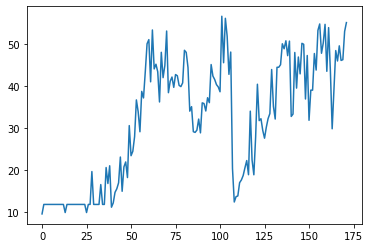

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.955226
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.850081
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.826974

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 1.911373
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.697589
Model client20 Train Ep

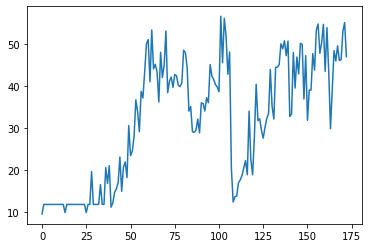

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.356983
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.077923
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000326

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.295727
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.144552
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.261409

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.202457
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.269788
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.122522

Power Allo

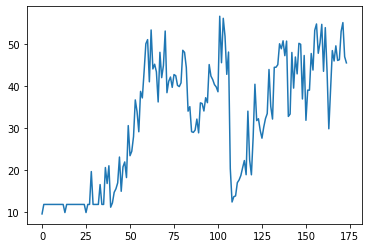

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.077135
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.538699
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.339508

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.084443
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.664572
Model client20 Train Ep

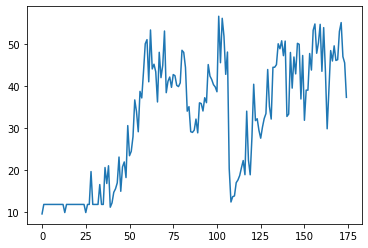

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.272690
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 0.174161
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.084526

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.451282
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.211455
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.107918

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

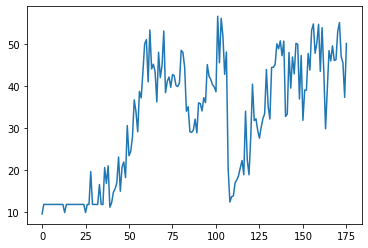

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.496216
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.335224
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000037

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 0.940307
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.237819
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.170878

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

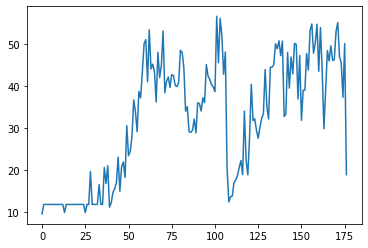

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.122958
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.309383
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.166833

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.049658
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.827041
Model client20 Train Ep

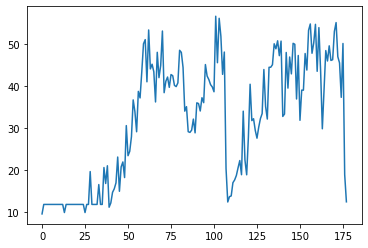

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.222482
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.001218
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.413257

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.309175
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.349536
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.287505

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

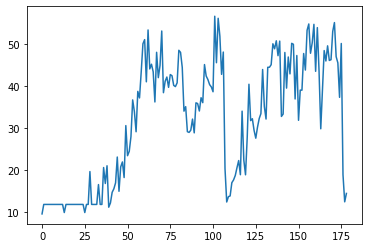

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.581728
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.335196
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.009108

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.284168
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.442264
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.342010

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

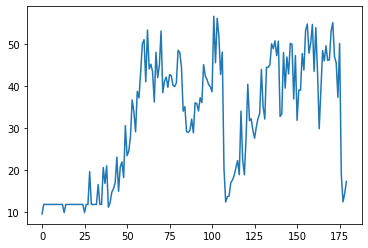

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.193064
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.334812
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.141744

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.240295
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.676891
Model client20 Train Ep

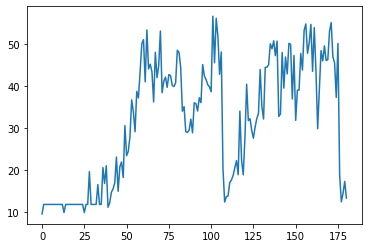

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.695281
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.375025
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.260602

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.363998
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.365486
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.264048

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

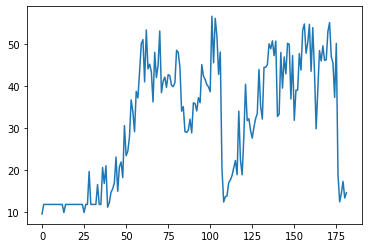

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.413909
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.294175
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.142967

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.959316
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.626655
Model client20 Train Ep

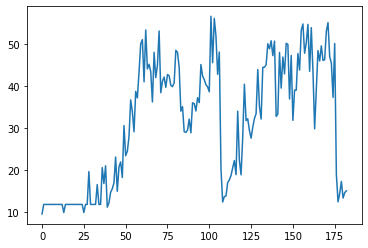

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.682516
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.363745
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002933

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.675124
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.225858
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.556500

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.383673
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.451322
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.233544

Power Allo

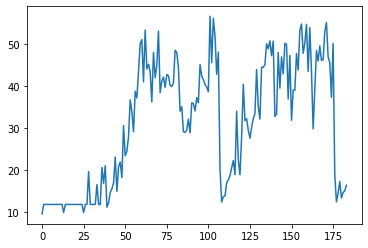

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.930015
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.315922
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.096497

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.338943
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.247094
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.161571

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

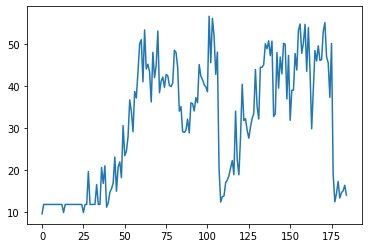

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.570870
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.758982
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.014963

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.385043
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.159369
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.237169

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

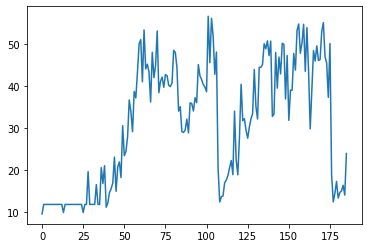

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.977991
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.341523
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.030319

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.970701
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.080036
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.140956

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

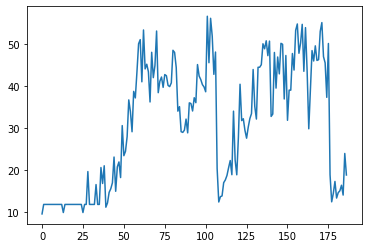

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.162048
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.195676
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.176518

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.088518
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.741853
Model client20 Train Ep

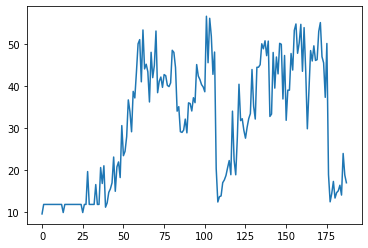

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.460278
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 1.012165
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.396128

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.256309
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.280261
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.196340

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

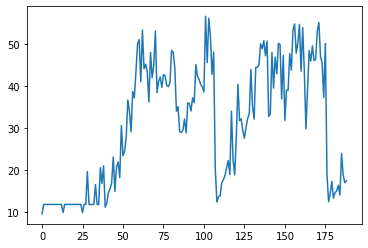

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 3.057414
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.396277
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.018515

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.448546
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.700343
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.600871

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 3.292131
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.095586
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.330068

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.232483
Model client

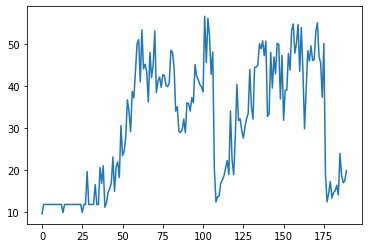

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.373615
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.431071
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.044362

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.212396
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.040596
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.191676

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

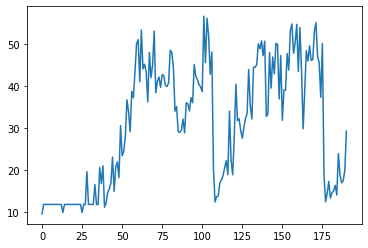

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.548620
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.363468
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.119571

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.919750
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.129233
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.326440

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

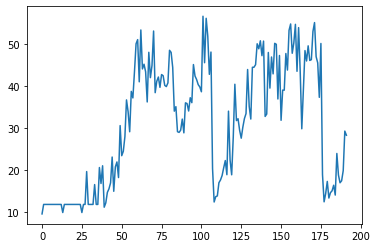

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Model client18 Train Epoch: 1 [0/320 (0%)]	Loss: 2.792397
Model client18 Train Epoch: 2 [0/320 (0%)]	Loss: 1.658913
Model client18 Train Epoch: 3 [0/320 (0%)]	Loss: 0.223962

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.935386
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.195059
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.121012

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

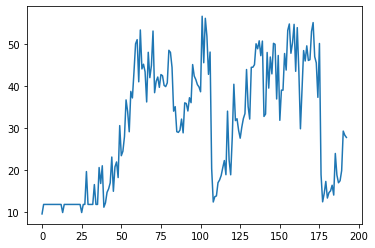

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.819537
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.178953
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.155418

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 2.921727
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.761160
Model client20 Train Ep

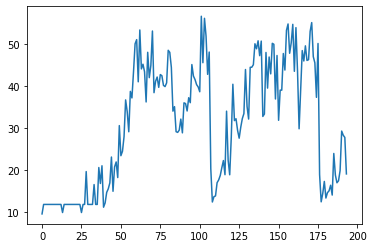

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.309256
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.635048
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 3.085710

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.187646
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.183025
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.038763

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

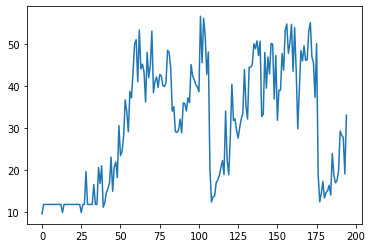

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.849812
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.077913
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.270719

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.354332
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.591028
Model client20 Train Ep

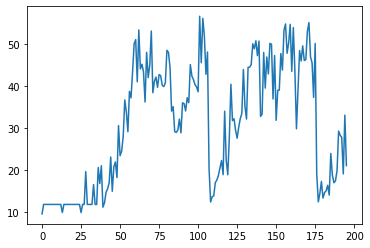

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.762114
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 1.756607
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.008528

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 2.383157
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.377011
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 1.774019

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.125192
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.152565
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.037276

Power Allo

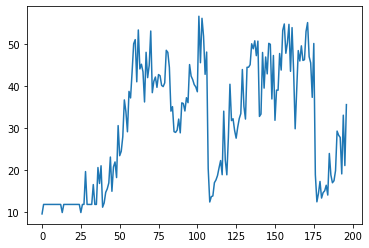

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Model client15 Train Epoch: 1 [0/320 (0%)]	Loss: 1.645986
Model client15 Train Epoch: 2 [0/320 (0%)]	Loss: 0.426061
Model client15 Train Epoch: 3 [0/320 (0%)]	Loss: 0.743212

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.554802
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.640545
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.066258

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

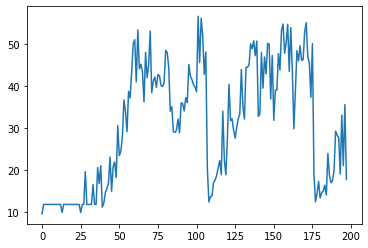

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 2.009184
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.260697
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.197977

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epoch: 1 [0/320 (0%)]	Loss: 3.420353
Model client20 Train Epoch: 2 [0/320 (0%)]	Loss: 0.755562
Model client20 Train Ep

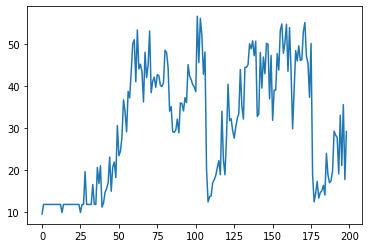

9
19

Power Allocated= 1.7829722175368306
CSI= 0.5160439171183087
SNR= 7.1837350354911536
Client: client14
Model client14 Train Epoch: 1 [0/320 (0%)]	Loss: 2.752453
Model client14 Train Epoch: 2 [0/320 (0%)]	Loss: 0.147082
Model client14 Train Epoch: 3 [0/320 (0%)]	Loss: 0.237547

Power Allocated= 2.47962266710934
CSI= 0.8056919770198989
SNR= 8.87626864266731
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4031155757738727
CSI= 0.7589117822601519
SNR= 7.1837350354911536
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0803433069398753
CSI= 0.6095893980725674
SNR= 27.03462813244918
Client: client19
Model client19 Train Epoch: 1 [0/320 (0%)]	Loss: 1.758966
Model client19 Train Epoch: 2 [0/320 (0%)]	Loss: 0.065477
Model client19 Train Epoch: 3 [0/320 (0%)]	Loss: 0.213915

Power Allocated= 2.4488572649045643
CSI= 0.7862039944669763
SNR= 23.344739405342587
Client: client20
Model client20 Train Epo

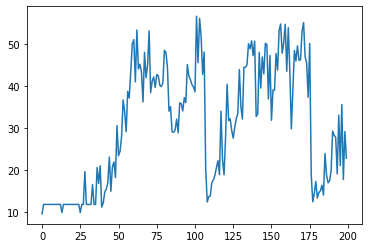

In [12]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    
acc1=[]
acc2=[]
acf=[]
rc=1
temp=[]
snrplot=[]
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters=cluster_former()
        temp=copy.deepcopy(arranged_clusters)
    else:
        #print(temp)
        arranged_clusters=copy.deepcopy(temp)
    
    
    
# #     uncomment if you want a random fraction for C every round
# #     args.C = float(format(np.random.random(), '.1f'))
    
#     # number of selected clients
#     m = int(max(args.C * args.clients, 1)) #at least 1 client is selected for training

#     # Selected devices
#     np.random.seed(fed_round)
#     selected_clients_inds = np.random.choice(range(len(clients)), m, replace=False)#dont choose same client more than once
#     selected_clients = [clients[i] for i in selected_clients_inds]
    
#     # Active devices
#     np.random.seed(fed_round)
#     active_clients_inds = np.random.choice(selected_clients_inds, int((1-args.drop_rate) * m), replace=False) #drop clients
#     active_clients = [clients[i] for i in active_clients_inds]
    
    members1=arranged_clusters[0]['Members']
    members2=arranged_clusters[1]['Members']
    print(len(members1))
    print(len(members2))
    new_members1=[]
    new_members2=[]
    
    for ij in members1:
        #print(ij)
        cl_no=int(ij[6:])
        new_members1.append(clients[cl_no-1])
    for ij in members2:
        #print(ij)
        cl_no=int(ij[6:])
        new_members2.append(clients[cl_no-1])
    
    arranged_clusters[0]['Members']=new_members1
    arranged_clusters[1]['Members']=new_members2
    
    cl_no=int(arranged_clusters[0]['Cluster Head'][6:])
    arranged_clusters[0]['Cluster Head']=clients[cl_no-1]
    cl_no=int(arranged_clusters[1]['Cluster Head'][6:])
    arranged_clusters[1]['Cluster Head']=clients[cl_no-1]
        
        
        
    #training members of individual clusters and considering cluster head as the global server for the time slot
    no=1
    
    for cluster in arranged_clusters:  
        client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round
        members=cluster['Members']
        snrlist=cluster['SNR']
        csilist=cluster['CSI']
        head=cluster['Cluster Head']
        snr=[]
        csi=[]
        for i in snrlist:
            snr.append(i[2])
        for i in csilist:
            csi.append(i[2])
        print()
        #print(csi)
        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csi:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
         
        good_mem=[]

        index=0
        for client in members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)


        head['model']=averageModels(head['model'], good_mem)
        ac=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        no+=1
        # for client in members:
        #     client['model'].load_state_dict(head['model'].state_dict())
        # cluster['Members']=members
        # cluster['Cluster Head']['model'].load_state_dict(head['model'].state_dict())
        
        # if(cluster==arranged_clusters[0]):
        #     acc1.append(ac)
        # elif(cluster==arranged_clusters[1]):
        #     acc2.append(ac)
    
    # if(acc1[-1]>=acc2[-1]):
    #     head=arranged_clusters[0]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # else:
    #     head=arranged_clusters[1]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # acf.append(test(args,head['model'], device, global_test_loader, "Final",fed_round))


    snrsum1=0
    snrsum2=0
    for k in snrlist:
        if(arranged_clusters[0]["Cluster Head"]['hook'].id in k):
            snrsum1+=k[2]
        else:
            snrsum2+=k[2]
    
    #print(snrsum1,snrsum2)

    weight1=snrsum1/(snrsum1+snrsum2)
    weight2=snrsum2/(snrsum1+snrsum2)
    snrplot.append((snrsum1+snrsum2)/len(snrlist))
    
    head1=arranged_clusters[0]["Cluster Head"]
    head2=arranged_clusters[1]["Cluster Head"]
    
    overall=averageModelscluster(overall,[head1,head2],[weight1,weight2])
    acf.append(test(args,overall, device, global_test_loader, "Final ",fed_round))
    index=0
    # for client in clients:
    #     client['model'].load_state_dict(overall.state_dict())
    #     client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #     index+=1
    for client in clients:
        client['model'].load_state_dict(overall.state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1)  #CHANGE: commented
        index+=1





    print(rc)
    rc+=1
    
    fig,ax=plt.subplots()
    ax.plot([i for i in range(len(acf))],acf)
    plt.show()
plt.show()
#plt.savefig('result_cluster.png')

In [13]:
print(acf)
print(snrplot)

[9.59, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 9.92, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 11.85, 9.92, 11.85, 11.85, 19.68, 11.85, 11.85, 11.85, 11.85, 16.58, 11.85, 11.85, 20.64, 16.84, 21.06, 11.19, 12.21, 14.73, 15.57, 16.99, 23.14, 14.98, 20.79, 21.97, 18.25, 30.63, 23.46, 24.51, 28.01, 36.75, 33.96, 29.16, 38.78, 37.22, 43.43, 50.12, 51.11, 41.06, 53.41, 44.13, 45.25, 43.45, 36.26, 48.09, 42.05, 44.96, 53.16, 38.47, 41.19, 42.2, 39.74, 42.79, 42.51, 40.21, 39.92, 40.81, 48.57, 48.07, 44.48, 34.07, 35.14, 29.18, 29.01, 29.55, 32.18, 28.9, 36.05, 35.88, 34.11, 37.27, 36.09, 45.17, 42.43, 41.6, 40.39, 39.84, 38.69, 56.68, 45.61, 56.19, 51.93, 42.84, 48.15, 20.39, 12.43, 13.7, 13.87, 17.03, 17.68, 18.74, 20.59, 22.3, 18.93, 34.07, 22.42, 18.91, 27.9, 40.48, 31.82, 32.26, 29.49, 27.63, 30.24, 32.3, 33.49, 43.99, 35.2, 32.19, 44.52, 44.53, 45.14, 50.12, 48.93, 50.83, 47.29, 50.76, 32.81, 33.38, 48.05, 39.56, 46